In [206]:
%matplotlib inline
from importlib import reload

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', palette='muted')

from types import SimpleNamespace

from TreeMazeAnalyses2.Analyses import subject_info as si
import TreeMazeAnalyses2.Analyses.tree_maze_functions as tmf
import Analyses.spatial_functions as spatial_funcs
import Utils.filter_functions as filter_funcs

from pykalman import KalmanFilter
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)


# Notebook to demonstrate behavioral data pre-processing

In [3]:
# load a session
si = reload(si)
session = 'Li_T3g_070618'
subject = session.split('_')[0]
session_info = si.SubjectSessionInfo(subject, session)

/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [256]:
parans = {
                # pixel params
                'x_pix_lims': [100, 650],  # camera field of view x limits [pixels]
                'y_pix_lims': [100, 500],  # camera field of view y limits [pixels]
                'x_pix_bias': -380,  # factor for centering the x pixel position
                'y_pix_bias': -280,  # factor for centering the y pixel position
                'vt_rate': 1.0 / 60.0,  # video acquisition frame rate
                'xy_pix_rot_rad': np.pi / 2 + 0.06,  # rotation of original xy pix camera to experimenter xy

                # conversion params
                'x_pix_mm': 1165.0 / 255.0,  # pixels to mm for the x axis [pix/mm]
                'y_pix_mm': 1320.0 / 329.0,  # pixels to mm for the y axis [pix/mm]
                'x_mm_bias': 20,  # factor for centering the x mm position
                'y_mm_bias': 650,  # factor for centering the y mm position
                'x_mm_lims': [-630, 630],  # limits on the x axis of the maze [mm]
                'y_mm_lims': [-60, 1350],  # limits on the y axis of the maze [mm]
                'x_cm_lims': [-63, 63],  # limits on the x axis of the maze [cm]
                'y_cm_lims': [-6, 135],  # limits on the y axis of the maze [cm]
                'max_speed_thr': 100, 
                'min_speed_thr': 2, 
                'temporal_window_size': 5,  # smoothing temporal window for filtering [bins]
                'temporal_angle_window_size': 5,  # smoothing temporal window for angles [bins]
                'temporal_window_type': 'hann',  # window type for temporal window smoothing

                # statistical tests parameters:
            }

parans['filter_coef_'] = si.signal.get_window(parans['temporal_window_type'],
                                                        parans['temporal_window_size'],
                                                        fftbins=False)
parans['filter_coef_'] /= parans['filter_coef_'].sum()
    
p = SimpleNamespace(**parans)

In [81]:
t_rs = session_info.get_time()
# get raw behavior
t_vt, x_vt, y_vt, ha_vt = session_info.get_raw_track_data()

(-30.700000000000003, 644.7, -23.75, 651.6500000000001)

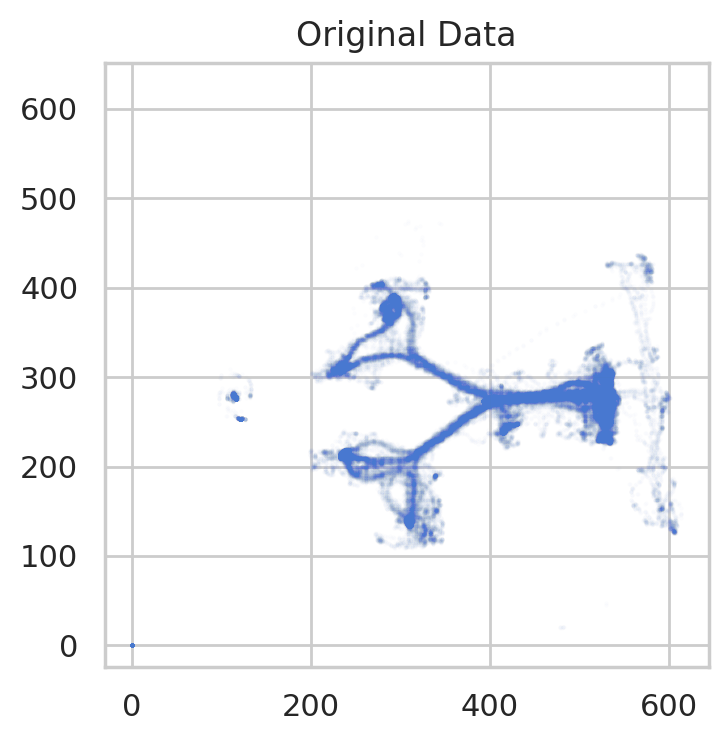

In [82]:
f,ax=plt.subplots(dpi=200)
ax.scatter(x_vt,y_vt, s=0.5, marker = '.', alpha=0.02)
ax.set_title("Original Data")
ax.axis("square")

(74.3, 639.7, 90.7, 656.1000000000001)

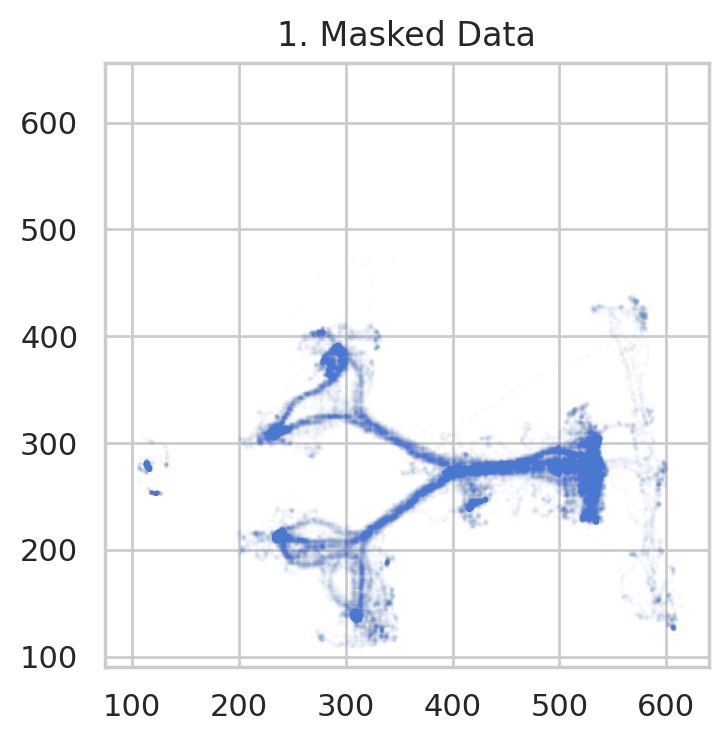

In [83]:
x = x_vt.copy()
y = y_vt.copy()
    
# 1. mask out of bound data
mask_x = np.logical_or(x < p.x_pix_lims[0], x > p.x_pix_lims[1])
mask_y = np.logical_or(y < p.y_pix_lims[0], y > p.y_pix_lims[1])
mask = np.logical_or(mask_x, mask_y)

x[mask] = np.nan
y[mask] = np.nan

f,ax=plt.subplots(dpi=200)
ax.scatter(x, y, s=0.5, marker = '.', alpha=0.02)
ax.set_title("1. Masked Data")
ax.axis("square")
#ax.set_xticks(np.arange(200,600,20))
#ax.set_xticklabels([])
# ax.set_yticks(np.arange(100,400,10))
# ax.set_yticklabels([])
# ax.set_ylim((100,400))

(-305.7, 259.7, -189.3, 376.09999999999997)

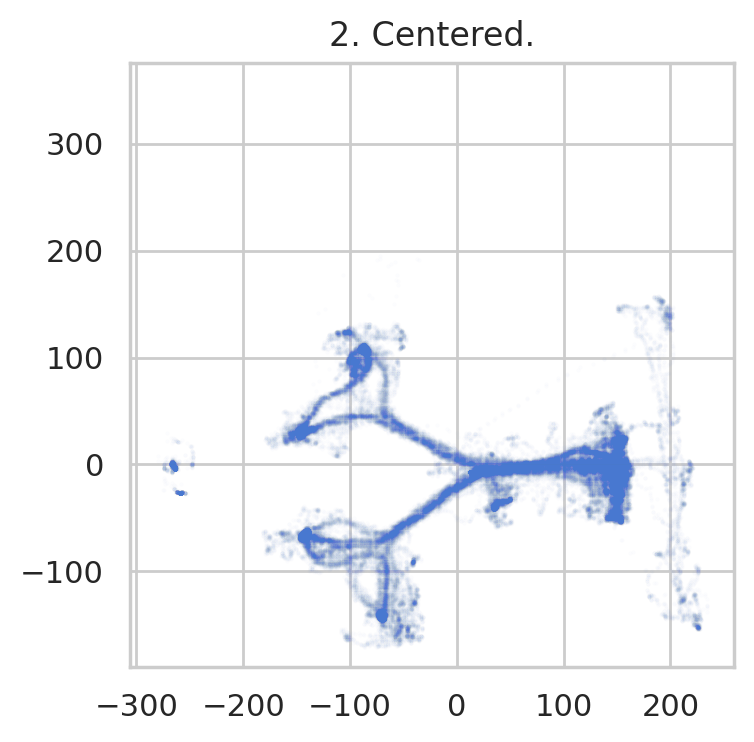

In [84]:
# 2. centering / pixel translation
x2 = x + p.x_pix_bias
y2 = y + p.y_pix_bias
f,ax=plt.subplots(dpi=200)
ax.scatter(x2, y2, s=0.5, marker = '.', alpha=0.02)
ax.set_title("2. Centered.")
ax.axis("square")

(-185.7127361463958,
 370.16095661353535,
 -251.2904475629701,
 304.58324519696106)

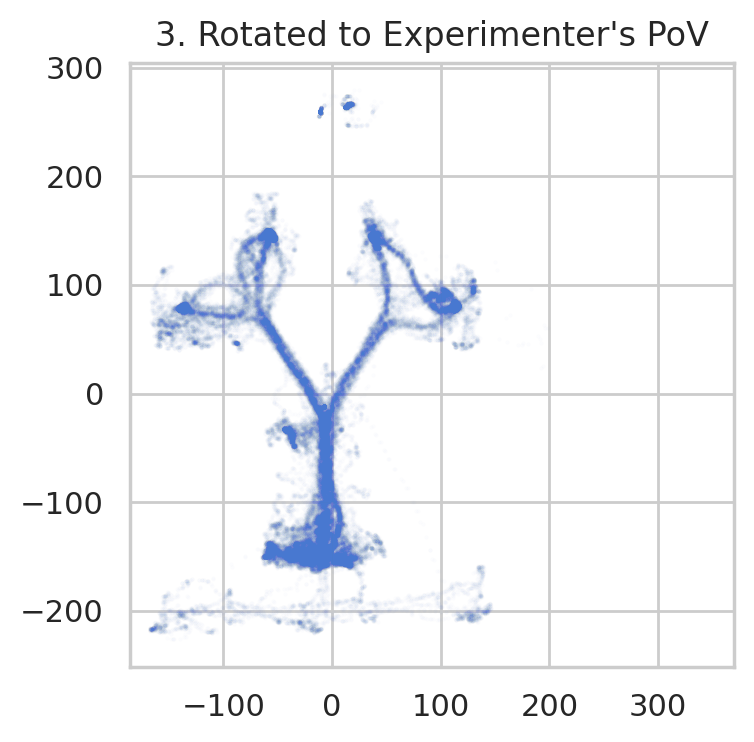

In [85]:
# 3. rotate to experimenter's pov
x3, y3 = spatial_funcs.rotate_xy(x2, y2, p.xy_pix_rot_rad)
f,ax=plt.subplots(dpi=200)
ax.scatter(x3, y3, s=0.5, marker = '.', alpha=0.02)
ax.set_title("3. Rotated to Experimenter's PoV")
ax.axis("square")

(-828.4523043551023,
 1401.8008094537406,
 -358.2169932617645,
 1872.0361205470786)

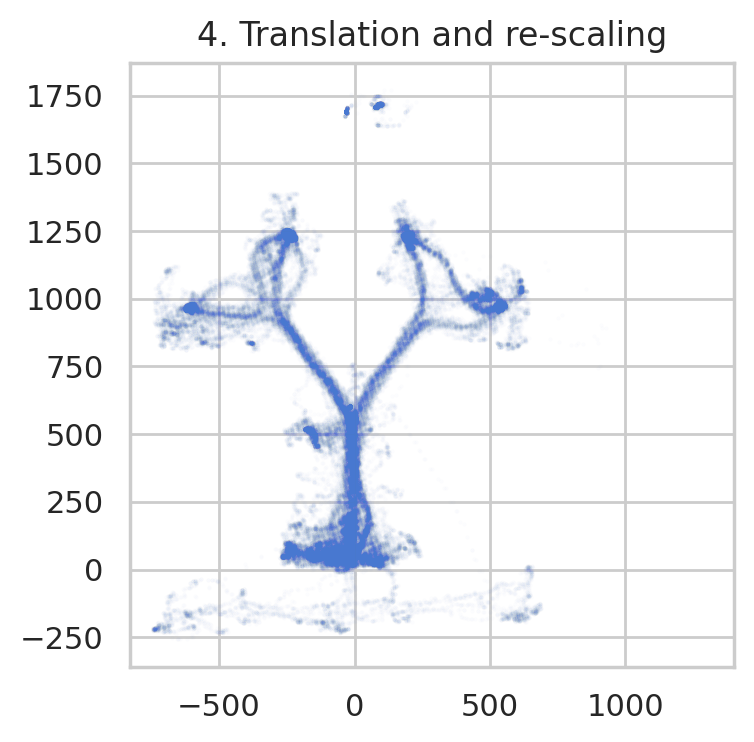

In [97]:
# 4. convert to mm / re-scales; bias term re-frames the image
x4 = x3 * p.x_pix_mm + p.x_mm_bias
y4 = y3 * p.y_pix_mm + p.y_mm_bias

f,ax=plt.subplots(dpi=200)
ax.scatter(x4, y4, s=0.5, marker = '.', alpha=0.02)
ax.set_title("4. Translation and re-scaling")
ax.axis("square")

(-684.2205888148134, 874.5413036393251, -135.7662340674091, 1422.9956583867292)

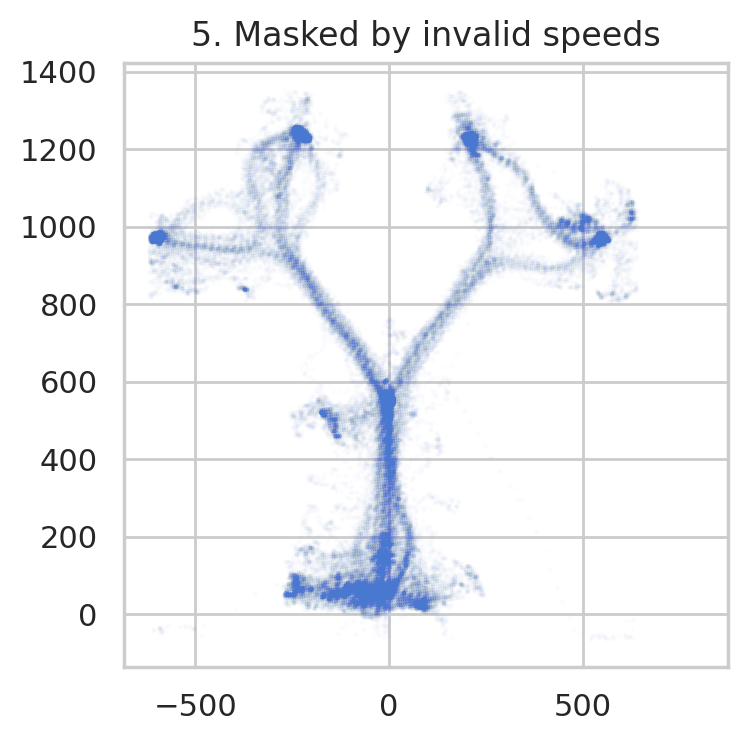

In [152]:
with np.errstate(invalid='ignore'):  # avoids warnings about comparing nan values
    # 5. compute velocity to create speed threshold
    dx = np.append(0, np.diff(x4))
    dy = np.append(0, np.diff(y4))
    dr = np.sqrt(dx ** 2 + dy ** 2)
    mask_r = np.abs(dr) > p.max_speed_thr

    # 6. mask creating out of bound zones in mm space
    mask_x = np.logical_or(x4 < p.x_mm_lims[0], x4 > p.x_mm_lims[1])
    mask_y = np.logical_or(y4 < p.y_mm_lims[0], y4 > p.y_mm_lims[1])
    mask = np.logical_or(mask_x, mask_y)
    mask = np.logical_or(mask, mask_r)

# 7. apply masks
x5[mask] = np.nan
y5[mask] = np.nan

f,ax=plt.subplots(dpi=200)
ax.scatter(x5, y5, s=0.5, marker = '.', alpha=0.02)
ax.set_title("5. Masked by invalid speeds")
ax.axis("square")

(-674.7484109034963,
 863.9104622061723,
 -127.97896517711918,
 1410.6799079325494)

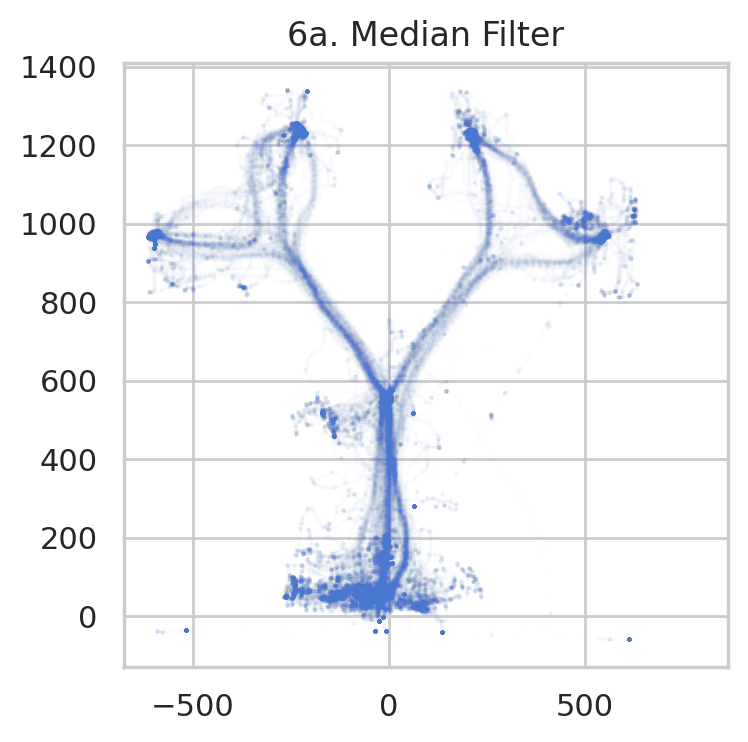

In [158]:
 # 8. median filter the data to deal with nan
x6a = filter_funcs.median_window_filtfilt(x5, 11)
y6a = filter_funcs.median_window_filtfilt(y5, 11)

f,ax=plt.subplots(dpi=200)
ax.scatter(x6a, y6a, s=0.5, marker = '.', alpha=0.02)
ax.set_title("6a. Median Filter")
ax.axis("square")


(-684.2205888148134, 874.5413036393251, -135.7662340674091, 1422.9956583867292)

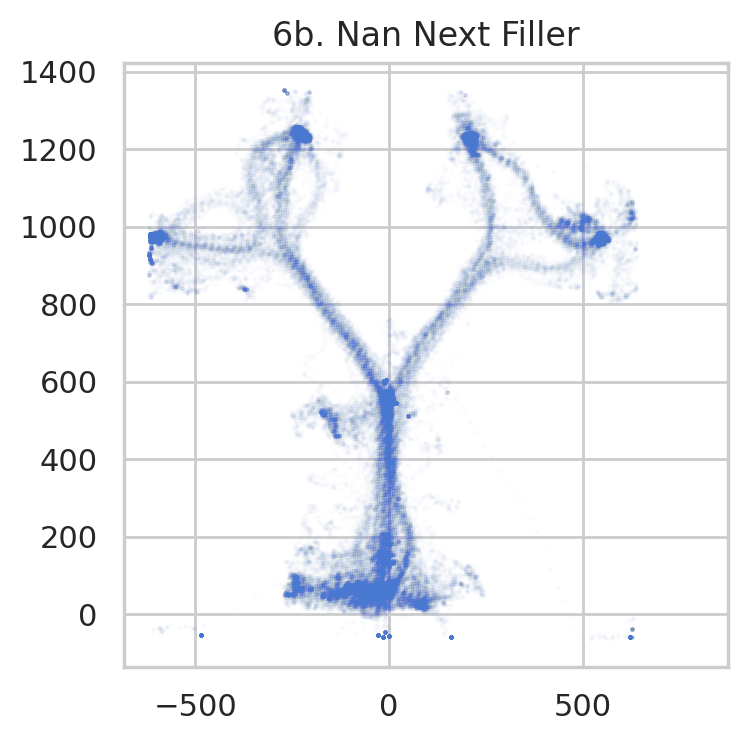

In [159]:
# 9. if there are still NaNs assign id to previous value
filter_funcs = reload(filter_funcs)

x6b = filter_funcs.fill_nan_vals(x5)
y6b = filter_funcs.fill_nan_vals(y5)

f,ax=plt.subplots(dpi=200)
ax.scatter(x6b, y6b, s=0.5, marker = '.', alpha=0.02)
ax.set_title("6b. Nan Next Filler")
ax.axis("square")

/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(-684.2205888148134, 874.5413036393251, -135.7662340674091, 1422.9956583867292)

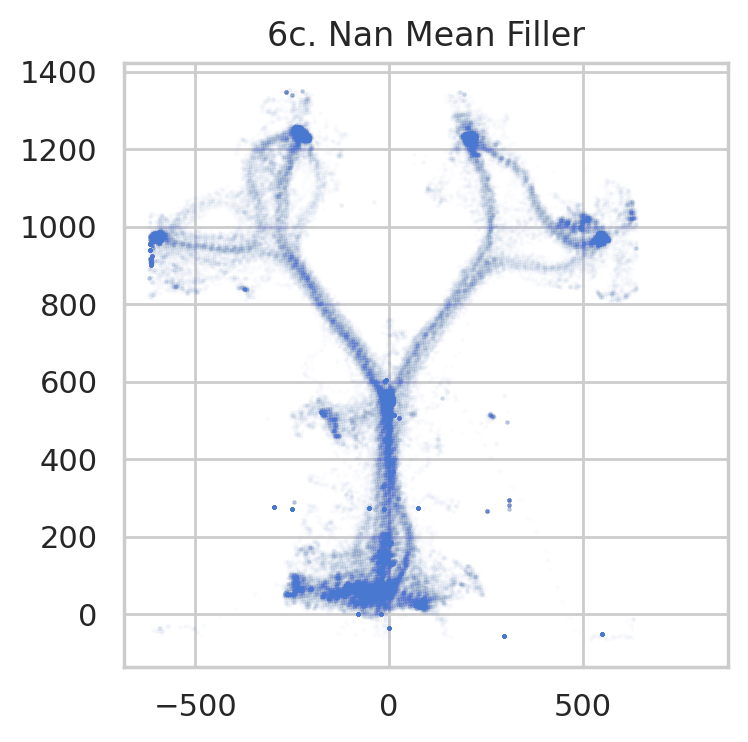

In [163]:
# 9. if there are still NaNs assign id to previous value
filter_funcs = reload(filter_funcs)

x6c = filter_funcs.fill_nan_vals(x5, method='Both')
y6c = filter_funcs.fill_nan_vals(y5, method='Both')

f,ax=plt.subplots(dpi=200)
ax.scatter(x6c, y6c, s=0.5, marker = '.', alpha=0.02)
ax.set_title("6c. Nan Mean Filler")
ax.axis("square")

(-683.3091827725174,
 872.0800480403792,
 -132.54687522804204,
 1422.8423555848544)

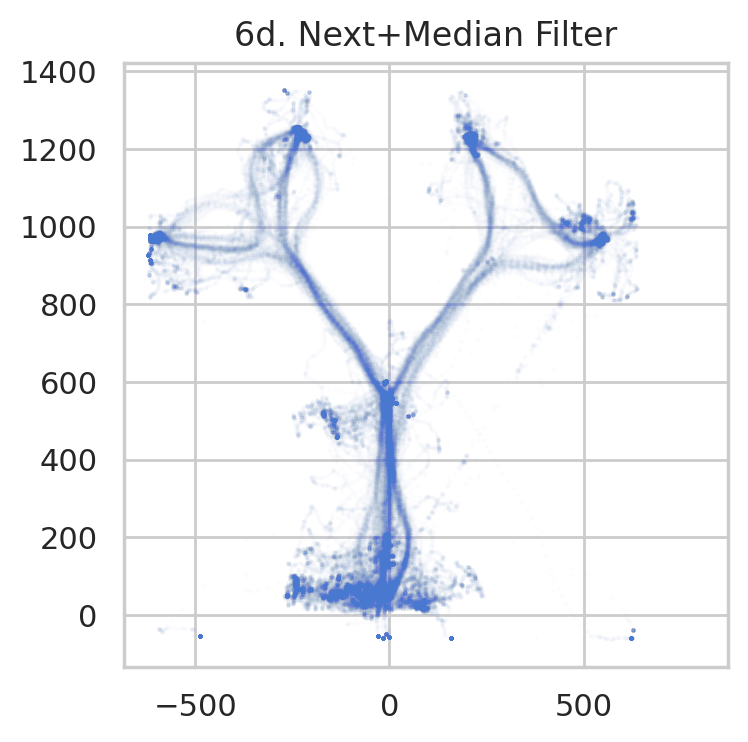

In [236]:
 # 8. median filter the data to deal with nan
x6d = filter_funcs.median_window_filtfilt(x6b, 5)
y6d = filter_funcs.median_window_filtfilt(y6b, 5)

f,ax=plt.subplots(dpi=200)
ax.scatter(x6d, y6d, s=0.5, marker = '.', alpha=0.02)
ax.set_title("6d. Next+Median Filter")
ax.axis("square")

In [231]:
%%time
#kalman
measurements = np.array((x5,y5)).T
measurements[nan_ids,:] = np.ma.masked
m_cov = np.cov(measurements.T)

transition_matrix = [[1, 1, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, 1, 1],
                     [0, 0, 0, 1]]

observation_matrix = [[1, 0, 0, 0],
                      [0, 0, 1, 0]]

kf = KalmanFilter(transition_matrices = transition_matrix,
                  observation_matrices = observation_matrix,
                  #initial_state_mean = [x5[0],0,y5[0],0],
                  observation_covariance = m_cov,
                  em_vars=['transition_covariance', 'initial_state_covariance']
                 )

kf = kf.em(measurements, n_iter=5)
(smoothed_state_means, smoothed_state_covariances) = kf.smooth(measurements)


CPU times: user 4min 49s, sys: 159 ms, total: 4min 50s
Wall time: 4min 48s


(-690.4916771644185,
 827.0249358336456,
 -124.44619430718058,
 1393.0704186908836)

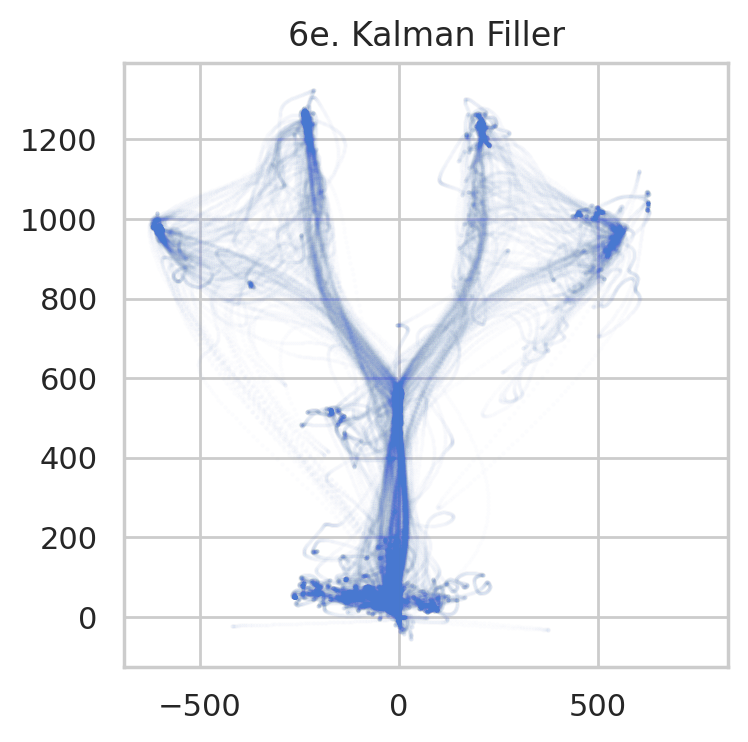

In [234]:
x6e = smoothed_state_means[:,0]
y6e = smoothed_state_means[:,2]


f,ax=plt.subplots(dpi=200)
ax.scatter(x6e, y6e, s=0.5, marker = '.', alpha=0.02)
ax.set_title("6e. Kalman Filler")
ax.axis("square")


(-683.3149662694532,
 874.0352705376986,
 -134.41874458619455,
 1422.9314922209571)

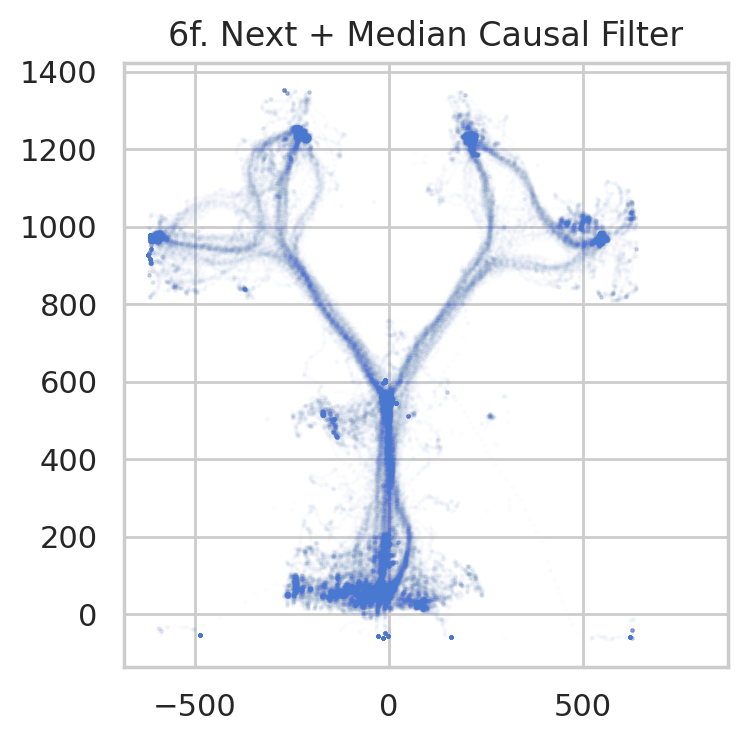

In [243]:
filter_funcs = reload(filter_funcs)

x6f = filter_funcs.median_window_filter_causal(x6b, 3)
y6f = filter_funcs.median_window_filter_causal(y6b, 3)

f,ax=plt.subplots(dpi=200)
ax.scatter(x6f, y6f, s=0.5, marker = '.', alpha=0.02)
ax.set_title("6f. Next + Median Causal Filter")
ax.axis("square")

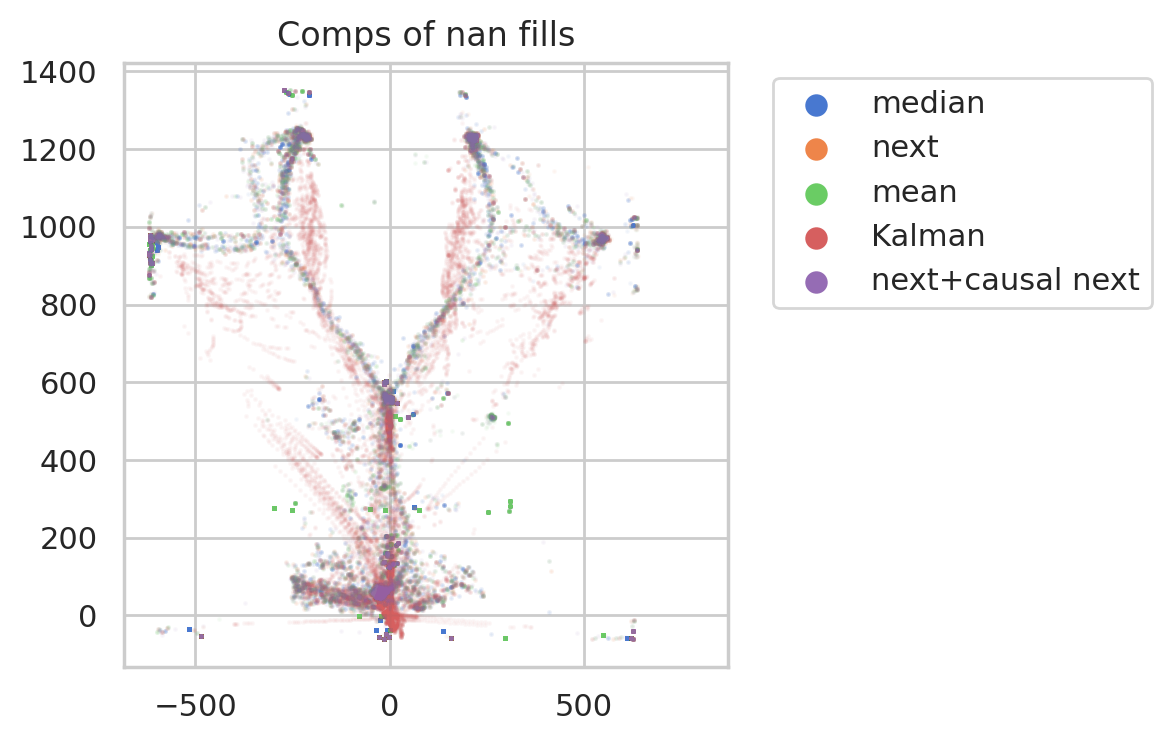

In [290]:
nan_ids = np.where(np.logical_or(np.isnan(x5), np.isnan(y5)))[0]

f,ax=plt.subplots(dpi=200)
ax.scatter(x6a[nan_ids], y6a[nan_ids], s=0.5, marker = 'o', alpha=0.05, label='median')
ax.scatter(x6b[nan_ids], y6b[nan_ids], s=0.5, marker = 'o', alpha=0.05, label='next')
ax.scatter(x6c[nan_ids], y6c[nan_ids], s=0.5, marker = 'o', alpha=0.05, label='mean')
ax.scatter(x6e[nan_ids], y6e[nan_ids], s=0.5, marker = 'o', alpha=0.05, label='Kalman')
ax.scatter(x6f[nan_ids], y6f[nan_ids], s=0.5, marker = 'o', alpha=0.05, label='next+causal next')


ax.set_title("Comps of nan fills")
ax.axis("square")
l = ax.legend(markerscale=10, bbox_to_anchor=(1.05, 1))
for lh in l.legendHandles: 
    lh.set_alpha(1)

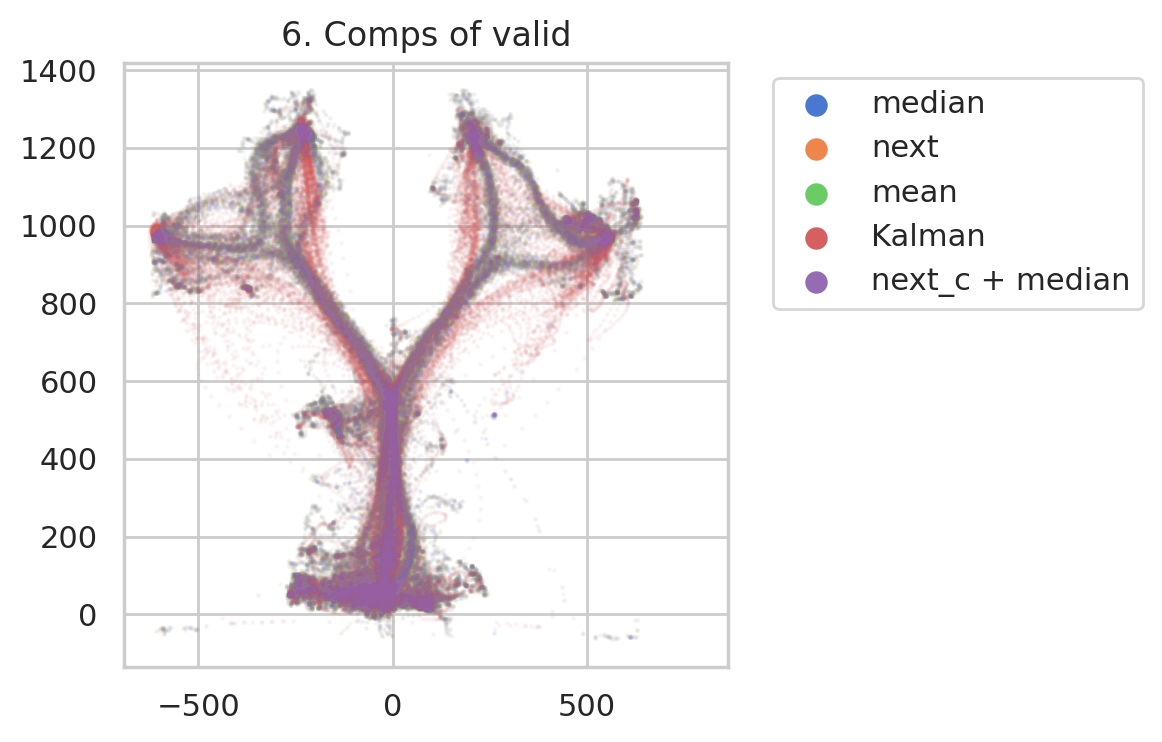

In [251]:
non_nan_ids = np.where(~np.logical_or(np.isnan(x5), np.isnan(y5)))[0]

non_nan_ids = non_nan_ids[::3]
f,ax=plt.subplots(dpi=200)
ax.scatter(x6a[non_nan_ids], y6a[non_nan_ids], s=0.5, marker = 'o', alpha=0.05, label='median')
ax.scatter(x6b[non_nan_ids], y6b[non_nan_ids], s=0.5, marker = 'o', alpha=0.05, label='next')
ax.scatter(x6c[non_nan_ids], y6c[non_nan_ids], s=0.5, marker = 'o', alpha=0.05, label='mean')
ax.scatter(x6e[non_nan_ids], y6e[non_nan_ids], s=0.5, marker = 'o', alpha=0.05, label='Kalman')
ax.scatter(x6f[non_nan_ids], y6f[non_nan_ids], s=0.5, marker = 'o', alpha=0.05, label='next_c + median')


ax.set_title("6. Comps of valid")
ax.axis("square")
l = ax.legend(markerscale=10, bbox_to_anchor=(1.05, 1))
for lh in l.legendHandles: 
    lh.set_alpha(1)

In [255]:
len(nan_ids)/len(x6)

0.08357466016715963

(-683.2756151368359, 871.513965606836, -131.97448198014678, 1422.8150987635252)

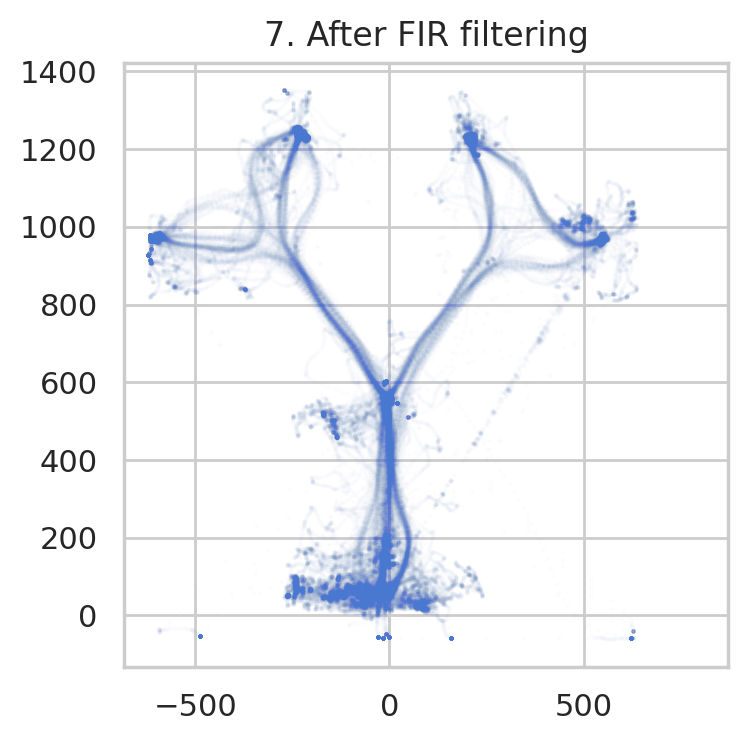

In [261]:
# 10. final filter / smoothing
x7 = filter_funcs.filtfilt(p.filter_coef_, 1, x6f)
y7 = filter_funcs.filtfilt(p.filter_coef_, 1, y6f)

f,ax=plt.subplots(dpi=200)
ax.scatter(x9, y9, s=0.5, marker = '.', alpha=0.02)
ax.set_title("7. After FIR filtering")
ax.axis("square")

## Different approach for the last part of processing
Use smoothing filter on non nan values first, then use median filter / fill nan values. 



In [291]:
x6g =x5.copy()
y6g =y5.copy()

x6g[~nan_ids] =filter_funcs.filtfilt(p.filter_coef_, 1, x6g[~nan_ids]) 
y6g[~nan_ids] = filter_funcs.filtfilt(p.filter_coef_, 1, y6g[~nan_ids])

x6g = filter_funcs.fill_nan_vals(x6g)
y6g = filter_funcs.fill_nan_vals(y6g)

In [292]:
x7b = filter_funcs.median_window_filter_causal(x6g, 5)
y7b = filter_funcs.median_window_filter_causal(y6g, 5)


(-684.2205888148134, 874.5413036393251, -135.7662340674091, 1422.9956583867292)

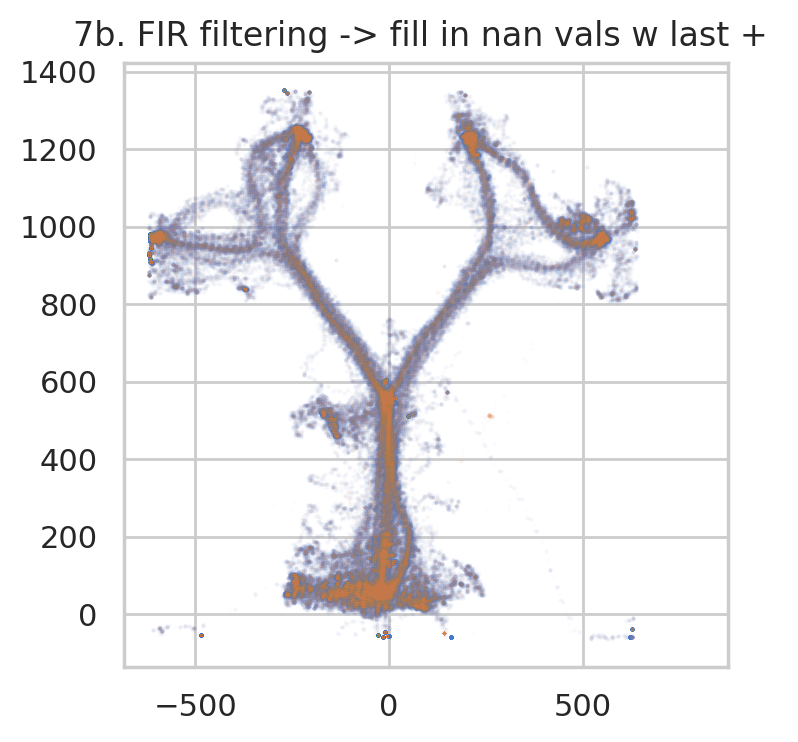

In [294]:

f,ax=plt.subplots(dpi=200)
ax.scatter(x6b, y6b, s=1, marker = '.', alpha=0.05)
ax.scatter(x7b, y7b, s=0.1, marker = '.', alpha=0.05)
ax.set_title("7b. FIR filtering -> fill in nan vals w last + ")
ax.axis("square")

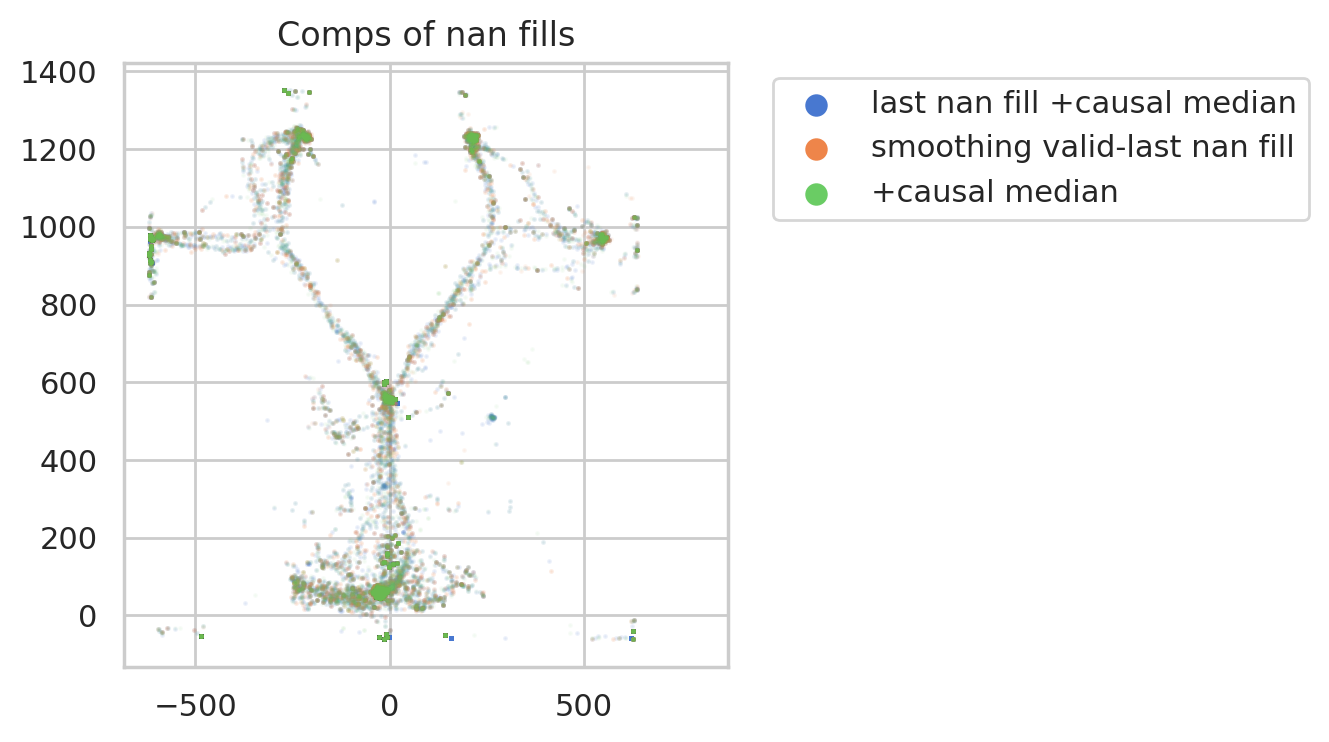

In [296]:
nan_ids = np.where(np.logical_or(np.isnan(x5), np.isnan(y5)))[0]

f,ax=plt.subplots(dpi=200)
ax.scatter(x6f[nan_ids], y6f[nan_ids], s=0.5, marker = 'o', alpha=0.1, label='last nan fill +causal median')
ax.scatter(x6g[nan_ids], y6g[nan_ids], s=0.5, marker = 'o', alpha=0.075, label='smoothing valid-last nan fill')
ax.scatter(x7b[nan_ids], y7b[nan_ids], s=0.5, marker = 'o', alpha=0.05, label='+causal median')

ax.set_title("Comps of nan fills")
ax.axis("square")
l = ax.legend(markerscale=10, bbox_to_anchor=(1.05, 1))
for lh in l.legendHandles: 
    lh.set_alpha(1)